# Workbook for testing ML on 3 years of ozone,aq data and met data from Rathmines

## Importing Modules and Dataset

In [262]:


import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm
from sklearn.decomposition import FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import FactorAnalysis
# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.svm import SVR

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [263]:
df = pd.read_csv('./corkdata.csv',thousands=',', low_memory=False)
# You can also open with Excel and take a look at it.

In [264]:
# Print first 5 rows of the dataframe
df.head(4)
df.dtypes

Date      object
Time       int64
ozone    float64
NOx      float64
NO       float64
NO2      float64
CO       float64
ind        int64
rain     float64
ind.1      int64
temp     float64
ind.2      int64
wetb     float64
dewpt    float64
vappr    float64
rhum       int64
msl      float64
ind.3      int64
wdsp       int64
ind.4      int64
wddir      int64
ww         int64
w          int64
sun      float64
vis        int64
clht       int64
clamt      int64
dtype: object

In [265]:
# Print last 5 rows of the dataframe
df.head(5)

,Date,Time,ozone,NOx,NO,NO2,CO,ind,rain,ind.1,...,ind.3,wdsp,ind.4,wddir,ww,w,sun,vis,clht,clamt
0,01/01/2014,1,NaN,NaN,NaN,NaN,NaN,0,0.1,0,...,2,10,2,220,80,81,0.0,20000,999,3
1,01/01/2014,2,NaN,NaN,NaN,NaN,NaN,0,0.1,0,...,2,8,2,200,25,81,0.0,20000,22,7
2,01/01/2014,3,NaN,NaN,NaN,NaN,NaN,3,0.0,0,...,2,9,2,190,2,11,0.0,20000,210,5
3,01/01/2014,4,NaN,NaN,NaN,NaN,NaN,3,0.0,0,...,2,9,2,180,3,81,0.0,20000,50,7
4,01/01/2014,5,NaN,NaN,NaN,NaN,NaN,0,0.3,0,...,2,11,2,180,60,62,0.0,15000,12,7


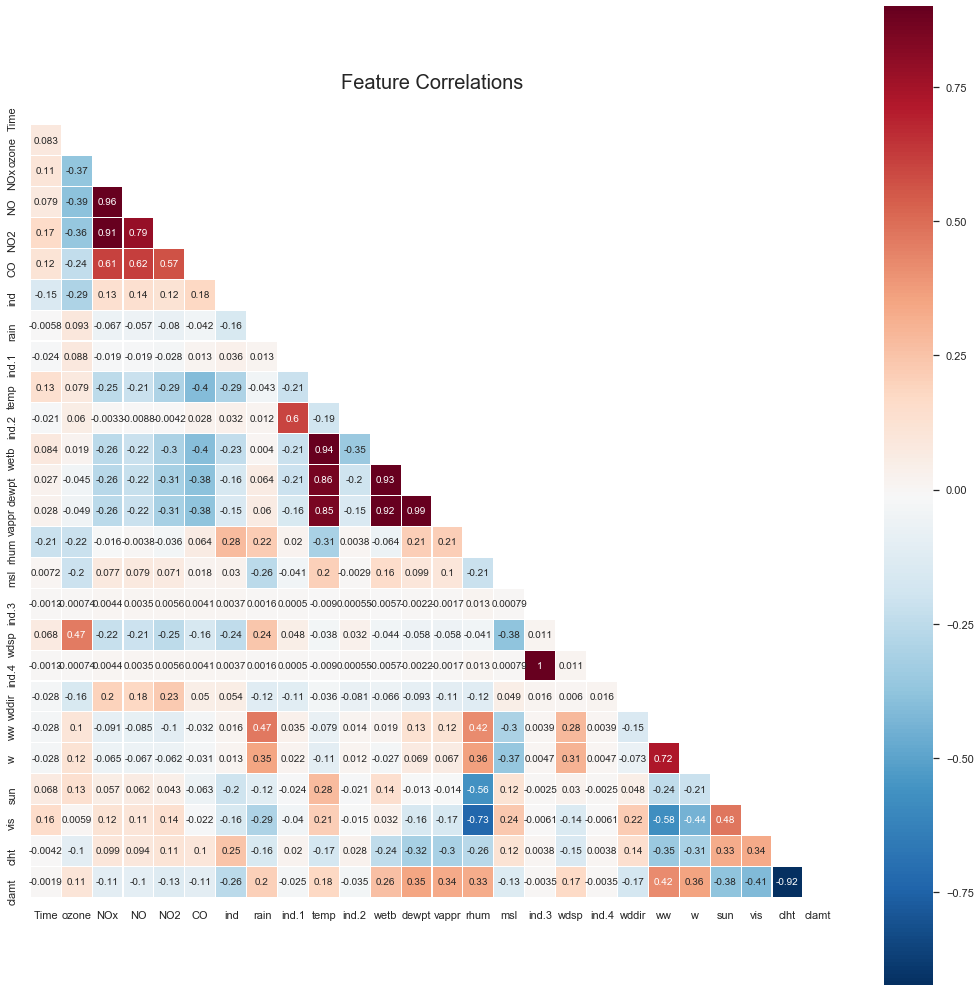

In [266]:
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.subplots(figsize = (18,18))
sns.heatmap(df.corr(), 
            annot=True,
            mask = mask,
            cmap = 'RdBu_r',
            linewidths=0.1, 
            linecolor='white',
            vmax = .9,
            square=True)
plt.title("Feature Correlations", y = 1.03,fontsize = 20)
plt.show()

# Lets have a look at the met data indicators

In [267]:
df['ind'].value_counts()

0    19073
3     4455
2     2752
Name: ind, dtype: int64

In [268]:
df['ind.1'].value_counts()

0    26106
1      174
Name: ind.1, dtype: int64

In [269]:
df['ind.2'].value_counts()

0    25996
1      276
5        8
Name: ind.2, dtype: int64

In [270]:
df['ind.3'].value_counts()

2    26279
0        1
Name: ind.3, dtype: int64

In [271]:
df['ind.4'].value_counts()

2    26279
0        1
Name: ind.4, dtype: int64

In [272]:
df.drop('ind', axis=1, inplace=True)

In [273]:
df.drop('ind.1', axis=1, inplace=True)

In [274]:
df.drop('ind.2', axis=1, inplace=True)

In [275]:
df.drop('ind.3', axis=1, inplace=True)

In [276]:
df.drop('ind.4', axis=1, inplace=True)

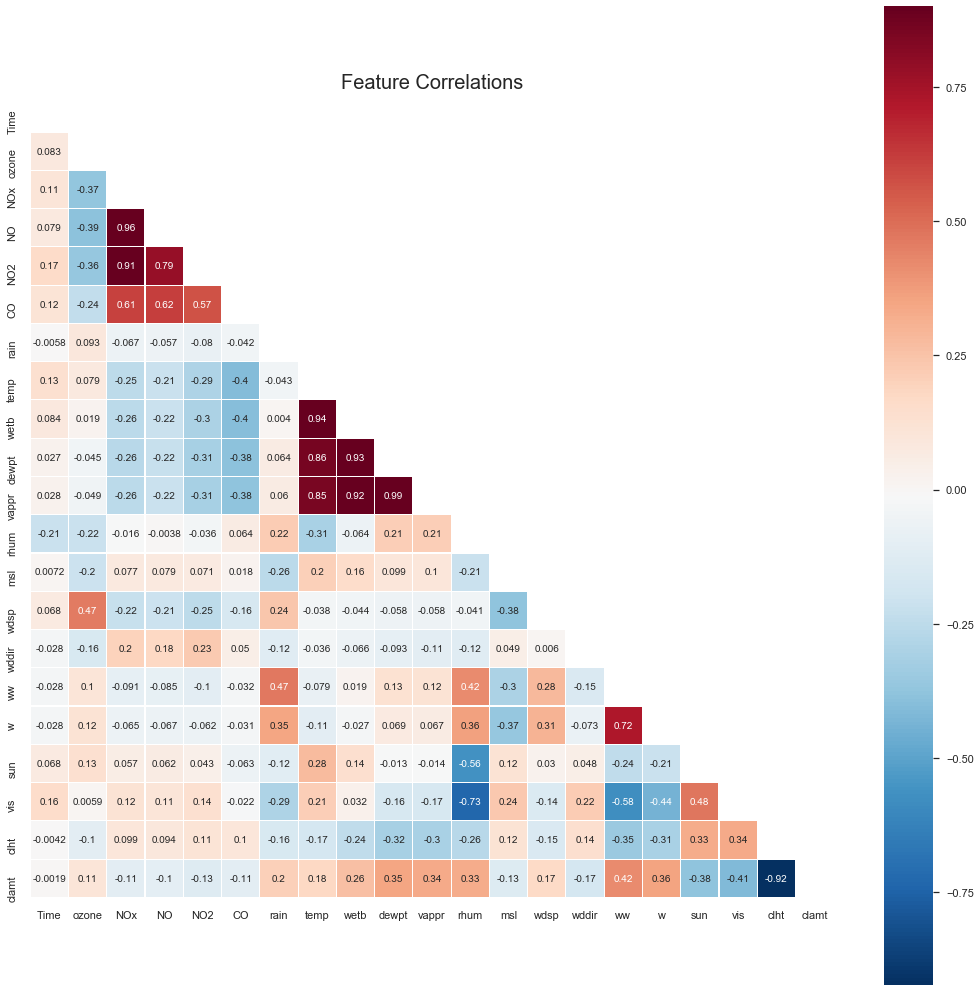

In [277]:
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.subplots(figsize = (18,18))
sns.heatmap(df.corr(), 
            annot=True,
            mask = mask,
            cmap = 'RdBu_r',
            linewidths=0.1, 
            linecolor='white',
            vmax = .9,
            square=True)
plt.title("Feature Correlations", y = 1.03,fontsize = 20)
plt.show()

# Just to keep things simple, I get rid of the follwing colums

In [278]:
df.drop('Date', axis=1, inplace=True)

In [279]:
df.drop('ww', axis=1, inplace=True)

In [280]:
df.drop('w', axis=1, inplace=True)

In [281]:
df.drop('clamt', axis=1, inplace=True)

In [282]:
df.drop('clht', axis=1, inplace=True)

In [283]:
df.drop('wetb', axis=1, inplace=True)

In [284]:
df.drop('dewpt', axis=1, inplace=True)

In [285]:
df.drop('vis', axis=1, inplace=True)

In [286]:
df.drop('rain', axis=1, inplace=True)

In [287]:
df.drop('vappr', axis=1, inplace=True)

# QUICK LOOK AT THE DATA TO MAKE SURE ALL OK

In [288]:
# Print statistical summary for all numerical attributes
df.describe()

,Time,ozone,NOx,NO,NO2,CO,temp,rhum,msl,wdsp,wddir,sun
count,26280.000000,22422.000000,19606.000000,19604.000000,19606.000000,21861.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000
mean,12.500000,32.199237,53.238376,22.475107,22.230123,0.327657,10.187348,86.668417,1013.384692,9.529490,215.063166,0.165822
std,6.922318,20.809282,65.726489,34.665026,19.250807,0.210495,4.599655,12.166796,12.403740,5.113437,82.575622,0.326579
min,1.000000,-4.000000,-6.700000,-4.800000,-4.800000,-0.200000,-6.900000,26.000000,951.500000,0.000000,0.000000,0.000000
25%,6.750000,17.400000,11.700000,2.600000,7.900000,0.200000,7.000000,80.000000,1006.300000,6.000000,170.000000,0.000000
50%,12.500000,29.800000,30.400000,10.000000,16.800000,0.300000,10.100000,90.000000,1015.200000,9.000000,230.000000,0.000000
75%,18.250000,44.200000,70.700000,28.800000,31.200000,0.400000,13.500000,96.000000,1021.800000,13.000000,280.000000,0.100000
max,24.000000,134.400000,908.300000,523.800000,132.400000,4.300000,26.200000,100.000000,1043.500000,45.000000,360.000000,1.000000


# HEATMAP

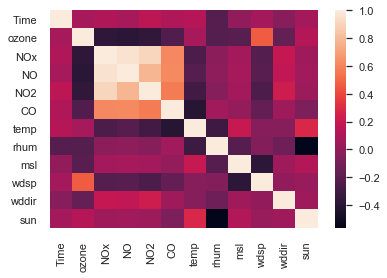

In [289]:
#correlation matrix
sns.heatmap(df.corr());

# XY Plots

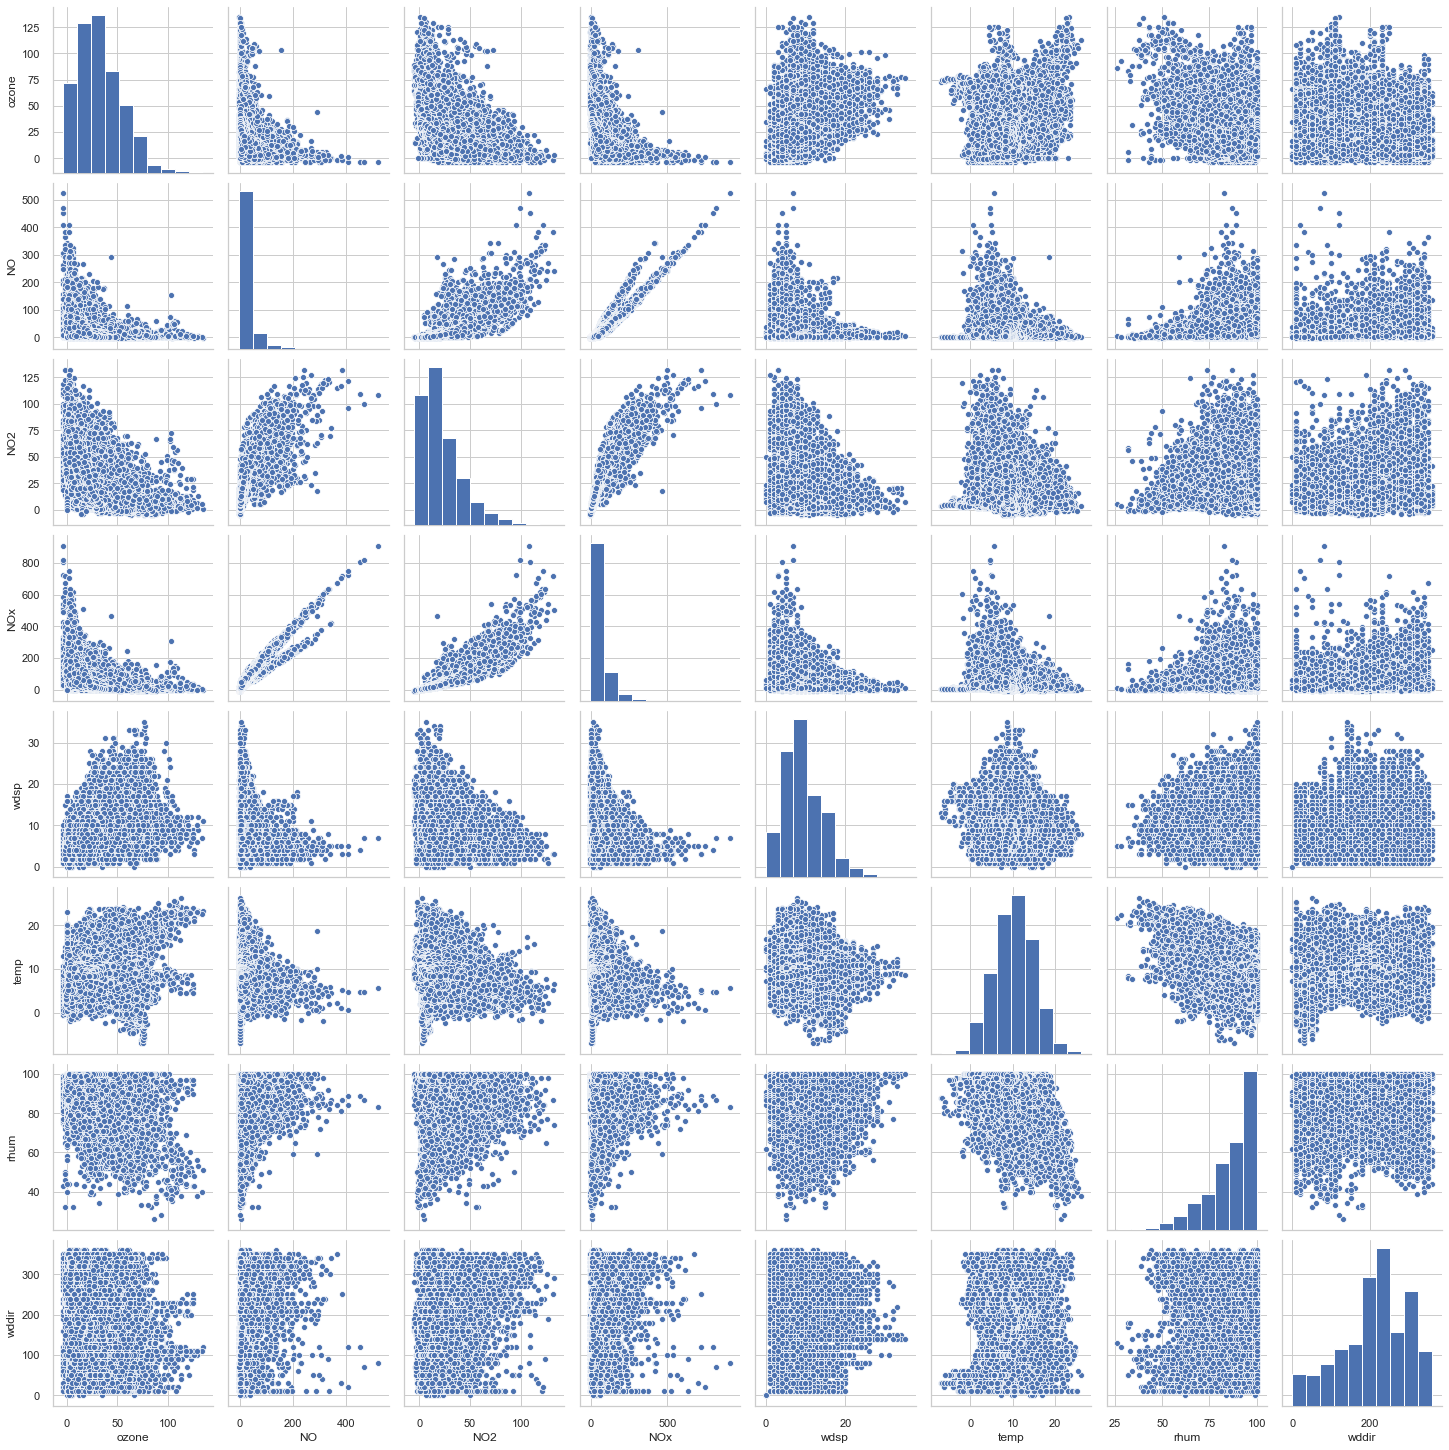

In [290]:
# note that by applying the method dropna() we drop all rows with missing values 
sns.pairplot(data=df[['ozone','NO','NO2','NOx','wdsp','temp','rhum','wddir']].dropna())
plt.show()

# Box Plots

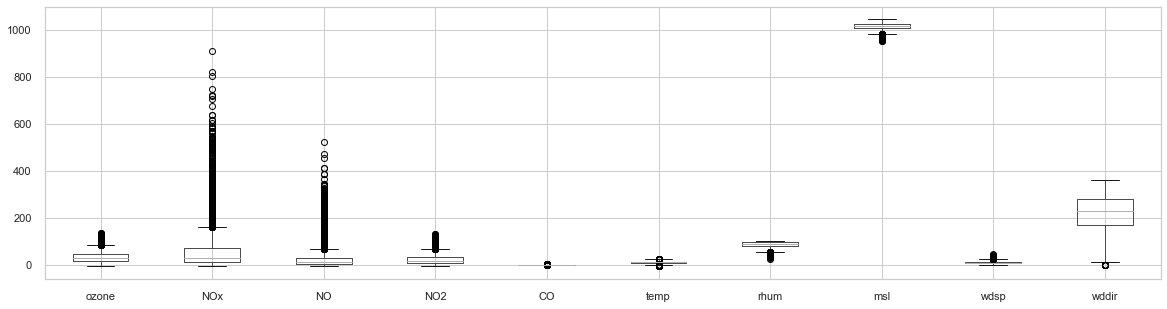

In [291]:
df.loc[:,'ozone':'wddir'].boxplot(figsize=(20,5))
plt.show()

# Histograms

In [292]:
df.isna().sum()

Time        0
ozone    3858
NOx      6674
NO       6676
NO2      6674
CO       4419
temp        0
rhum        0
msl         0
wdsp        0
wddir       0
sun         0
dtype: int64

# Dopping rows with nan's and missing data

In [293]:
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

In [294]:
df.isna().sum()

Time     0
ozone    0
NOx      0
NO       0
NO2      0
CO       0
temp     0
rhum     0
msl      0
wdsp     0
wddir    0
sun      0
dtype: int64

In [295]:
# Print statistical summary for all numerical attributes
df.describe()

,Time,ozone,NOx,NO,NO2,CO,temp,rhum,msl,wdsp,wddir,sun
count,18569.000000,18569.000000,18569.000000,18569.000000,18569.000000,18569.000000,18569.000000,18569.000000,18569.000000,18569.000000,18569.000000,18569.000000
mean,12.732942,32.140201,54.268340,22.925602,22.567343,0.341402,10.351381,86.286014,1014.825214,9.295385,212.124509,0.175104
std,6.788516,21.461111,66.563033,35.003614,19.442271,0.215566,4.604486,12.360235,11.698262,4.941007,85.539286,0.334336
min,1.000000,-4.000000,-6.700000,-4.800000,-4.800000,-0.200000,-6.900000,26.000000,967.700000,0.000000,0.000000,0.000000
25%,7.000000,16.300000,12.000000,2.800000,8.100000,0.200000,7.300000,79.000000,1008.000000,6.000000,160.000000,0.000000
50%,13.000000,28.600000,31.300000,10.500000,17.100000,0.300000,10.400000,89.000000,1016.300000,8.000000,230.000000,0.000000
75%,19.000000,45.600000,72.100000,29.500000,31.600000,0.400000,13.600000,96.000000,1023.000000,12.000000,280.000000,0.100000
max,24.000000,134.400000,908.300000,523.800000,132.400000,4.300000,26.200000,100.000000,1043.500000,35.000000,360.000000,1.000000


# Histograms 

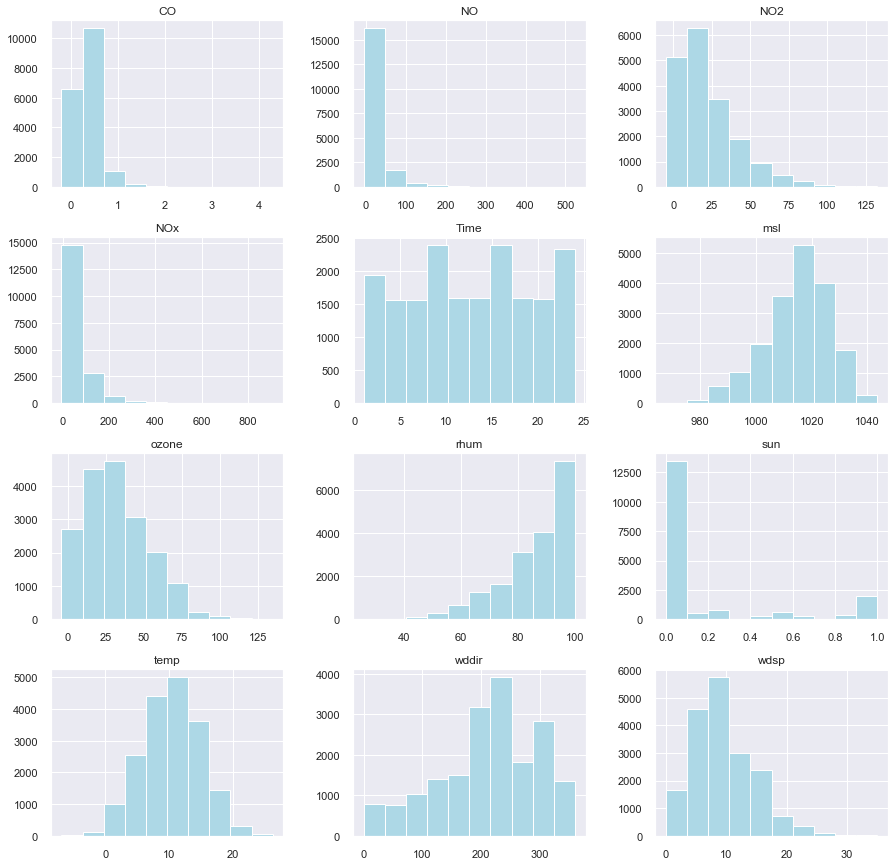

In [296]:
sns.set()
pd.DataFrame.hist(df, figsize = [15,15], color='lightblue')
plt.show()

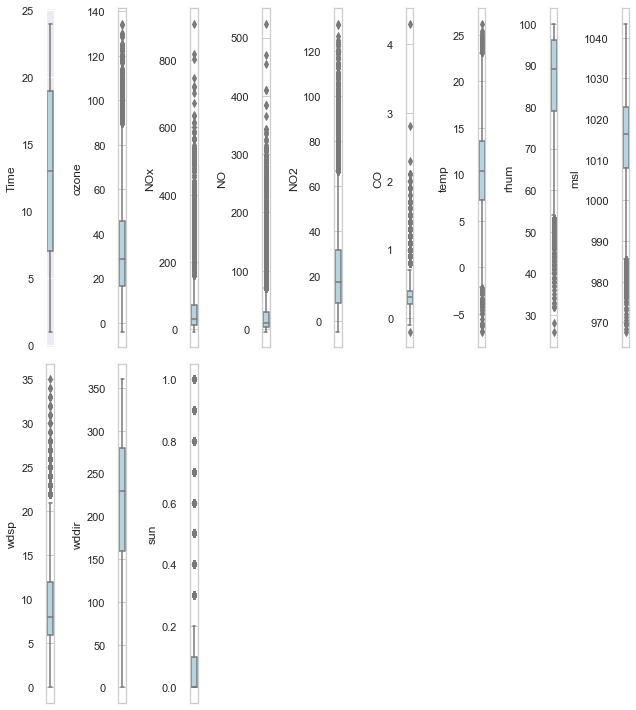

In [297]:

l = df.columns.values
number_of_columns=9
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(df[l[i]],color='lightblue',orient='v')
    plt.tight_layout()

# Distributions 

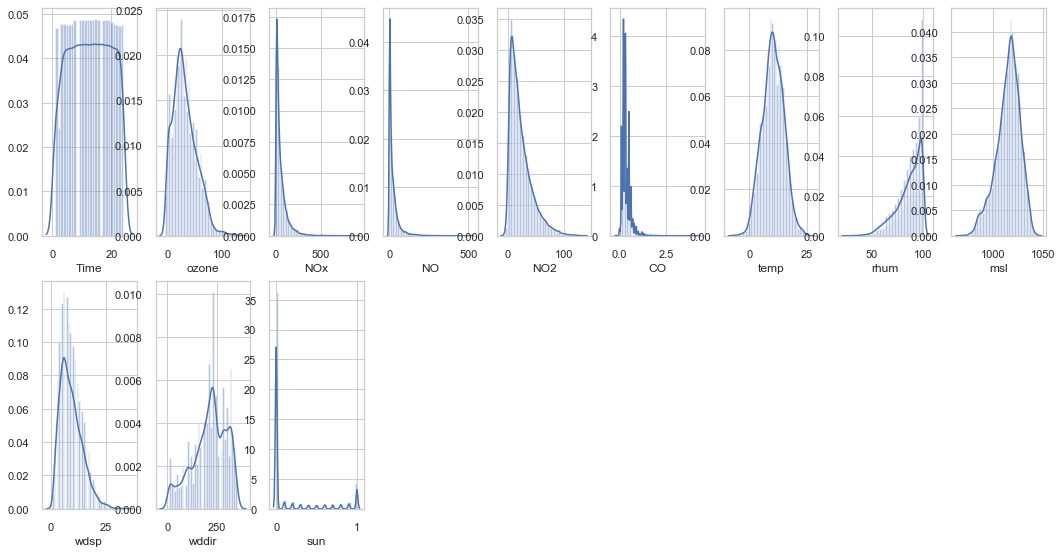

In [298]:

plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.distplot(df[l[i]],kde=True)

In [299]:
# Print statistical summary for all numerical attributes
df.describe()

,Time,ozone,NOx,NO,NO2,CO,temp,rhum,msl,wdsp,wddir,sun
count,18569.000000,18569.000000,18569.000000,18569.000000,18569.000000,18569.000000,18569.000000,18569.000000,18569.000000,18569.000000,18569.000000,18569.000000
mean,12.732942,32.140201,54.268340,22.925602,22.567343,0.341402,10.351381,86.286014,1014.825214,9.295385,212.124509,0.175104
std,6.788516,21.461111,66.563033,35.003614,19.442271,0.215566,4.604486,12.360235,11.698262,4.941007,85.539286,0.334336
min,1.000000,-4.000000,-6.700000,-4.800000,-4.800000,-0.200000,-6.900000,26.000000,967.700000,0.000000,0.000000,0.000000
25%,7.000000,16.300000,12.000000,2.800000,8.100000,0.200000,7.300000,79.000000,1008.000000,6.000000,160.000000,0.000000
50%,13.000000,28.600000,31.300000,10.500000,17.100000,0.300000,10.400000,89.000000,1016.300000,8.000000,230.000000,0.000000
75%,19.000000,45.600000,72.100000,29.500000,31.600000,0.400000,13.600000,96.000000,1023.000000,12.000000,280.000000,0.100000
max,24.000000,134.400000,908.300000,523.800000,132.400000,4.300000,26.200000,100.000000,1043.500000,35.000000,360.000000,1.000000


# Adjustment of data to avoid zero's

In [300]:
# Print statistical summary for all numerical attributes
# Use a log transformation to decrease the impact of outliers
df['wdsp'] = df['wdsp']+1.00
df['temp'] = df['temp']+7.50
df['wddir'] = df['wddir']/360 + 1.00

In [301]:
df['rhum'] = df['rhum']
df = df[df['NOx'] > 0.1]
df = df[df['NO'] > 0.1]
df = df[df['NO2'] > 0.1]
df = df[df['CO'] > 0.1]
df = df[df['ozone'] > 0.1]

In [302]:
# Print statistical summary for all numerical attributes
df.describe()

,Time,ozone,NOx,NO,NO2,CO,temp,rhum,msl,wdsp,wddir,sun
count,14971.000000,14971.000000,14971.000000,14971.000000,14971.000000,14971.000000,14971.000000,14971.000000,14971.000000,14971.000000,14971.000000,14971.000000
mean,13.142409,32.746056,58.965794,24.574197,24.692258,0.367016,17.485178,86.023713,1014.742876,10.462761,1.605244,0.183602
std,6.466678,20.923960,65.126619,33.601168,19.315544,0.193780,4.593677,12.355004,11.969114,4.927260,0.230982,0.340040
min,1.000000,0.200000,0.600000,0.200000,0.200000,0.200000,0.600000,26.000000,967.700000,1.000000,1.000000,0.000000
25%,8.000000,17.000000,15.900000,3.800000,10.100000,0.200000,14.400000,79.000000,1007.900000,7.000000,1.472222,0.000000
50%,13.000000,29.200000,37.100000,13.100000,19.500000,0.300000,17.500000,89.000000,1016.300000,10.000000,1.638889,0.000000
75%,19.000000,46.000000,78.600000,32.350000,34.200000,0.500000,20.600000,96.000000,1023.100000,13.000000,1.777778,0.200000
max,24.000000,130.000000,747.000000,409.500000,132.400000,4.300000,33.700000,100.000000,1043.500000,36.000000,2.000000,1.000000


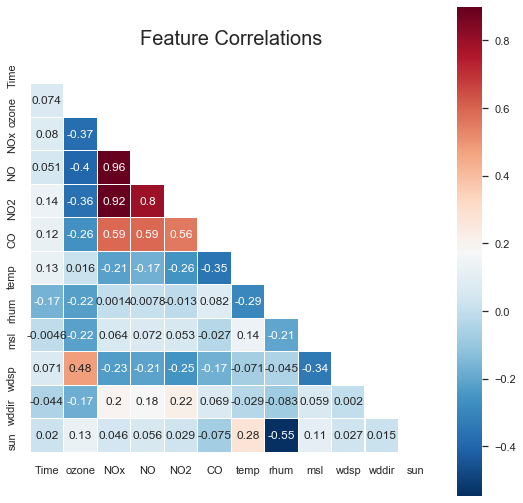

In [303]:
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.subplots(figsize = (9,9))
sns.heatmap(df.corr(), 
            annot=True,
            mask = mask,
            cmap = 'RdBu_r',
            linewidths=0.1, 
            linecolor='white',
            vmax = .9,
            square=True)
plt.title("Feature Correlations", y = 1.03,fontsize = 20)
plt.show()

In [304]:
# Print first 5 rows of the dataframe
df.dtypes

Time       int64
ozone    float64
NOx      float64
NO       float64
NO2      float64
CO       float64
temp     float64
rhum       int64
msl      float64
wdsp     float64
wddir    float64
sun      float64
dtype: object

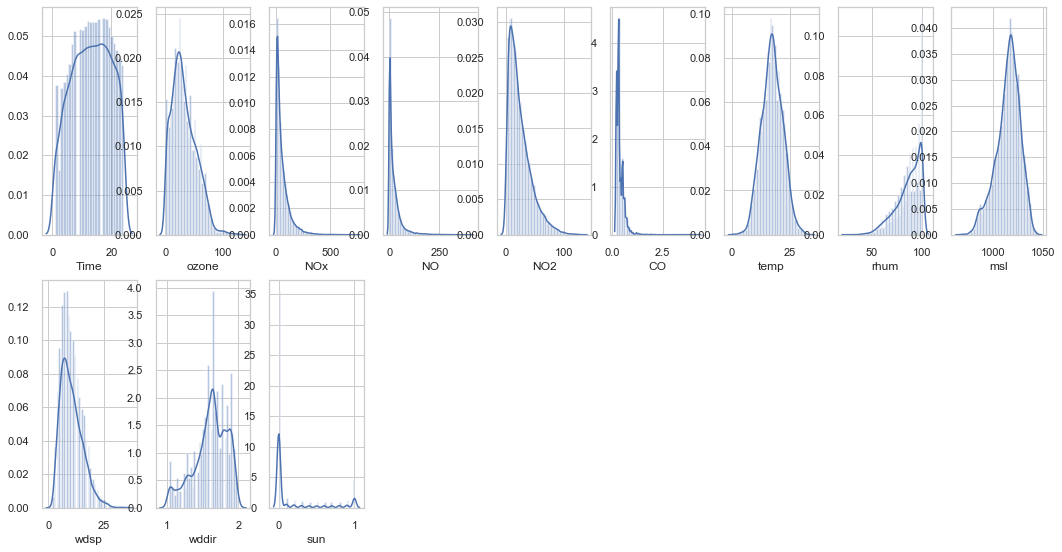

In [305]:

plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.distplot(df[l[i]],kde=True)

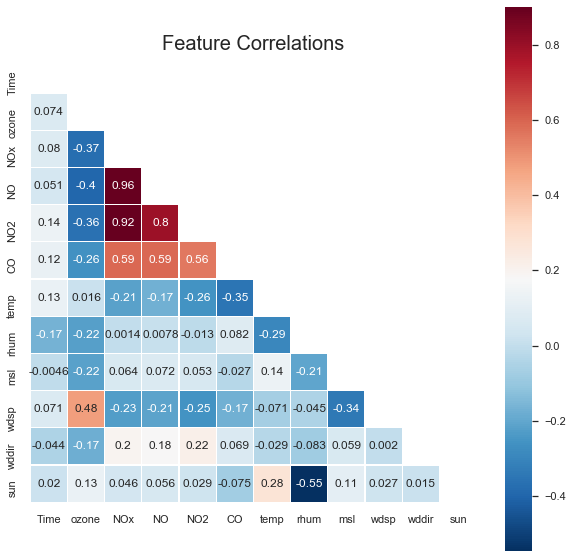

In [306]:
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.subplots(figsize = (10,10))
sns.heatmap(df.corr(), 
            annot=True,
            mask = mask,
            cmap = 'RdBu_r',
            linewidths=0.1, 
            linecolor='white',
            vmax = .9,
            square=True)
plt.title("Feature Correlations", y = 1.03,fontsize = 20)
plt.show()

In [307]:
# Print statistical summary for all numerical attributes
df.describe()

,Time,ozone,NOx,NO,NO2,CO,temp,rhum,msl,wdsp,wddir,sun
count,14971.000000,14971.000000,14971.000000,14971.000000,14971.000000,14971.000000,14971.000000,14971.000000,14971.000000,14971.000000,14971.000000,14971.000000
mean,13.142409,32.746056,58.965794,24.574197,24.692258,0.367016,17.485178,86.023713,1014.742876,10.462761,1.605244,0.183602
std,6.466678,20.923960,65.126619,33.601168,19.315544,0.193780,4.593677,12.355004,11.969114,4.927260,0.230982,0.340040
min,1.000000,0.200000,0.600000,0.200000,0.200000,0.200000,0.600000,26.000000,967.700000,1.000000,1.000000,0.000000
25%,8.000000,17.000000,15.900000,3.800000,10.100000,0.200000,14.400000,79.000000,1007.900000,7.000000,1.472222,0.000000
50%,13.000000,29.200000,37.100000,13.100000,19.500000,0.300000,17.500000,89.000000,1016.300000,10.000000,1.638889,0.000000
75%,19.000000,46.000000,78.600000,32.350000,34.200000,0.500000,20.600000,96.000000,1023.100000,13.000000,1.777778,0.200000
max,24.000000,130.000000,747.000000,409.500000,132.400000,4.300000,33.700000,100.000000,1043.500000,36.000000,2.000000,1.000000


## Data Preparation

In [308]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['ozone']]

# define column groups with the same data preparation
names_outliers = ['NO2', 'NO','wdsp','temp','rhum','NOx']
names_no_outliers = list(set(names_all) - set(names_outliers))

In [309]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

In [310]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

In [311]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()  
        ))
    ])
)

In [312]:
y = df['ozone']
X = df.drop('ozone', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True)

## Random Forest Regressor

In [313]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=100))])

In [314]:
N_FEATURES_OPTIONS = [7]
MAX_DEPTH_OPTIONS = [12]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [FastICA( algorithm='deflation')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [TruncatedSVD(algorithm='randomized'), TruncatedSVD(algorithm='arpack')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
    },
]    

search = GridSearchCV(pipe, param_grid, cv=10, iid = False, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

C:\Users\0110900s\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best CV score = 0.652:
Best parameters:  {'reduce_dim': PCA(copy=True, iterated_power=7, n_components=7, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), 'reduce_dim__n_components': 7, 'regresson__max_depth': 12}


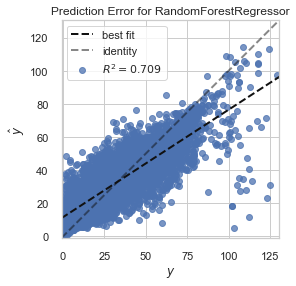

In [315]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from yellowbrick.regressor import PredictionError


model = RandomForestRegressor()
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

## Linear Regression

In [316]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

In [317]:
N_FEATURES_OPTIONS = [4]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [FastICA( algorithm='deflation')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [TruncatedSVD(algorithm='randomized'), TruncatedSVD(algorithm='arpack')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

C:\Users\0110900s\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best CV score = 0.387:
Best parameters:  {'reduce_dim': FastICA(algorithm='deflation', fun='logcosh', fun_args=None, max_iter=200,
        n_components=4, random_state=None, tol=0.0001, w_init=None,
        whiten=True), 'reduce_dim__n_components': 4, 'regresson__normalize': False}


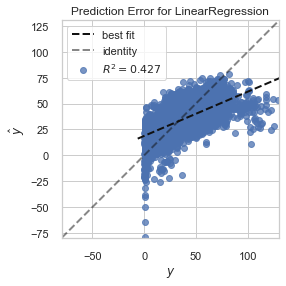

In [318]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from yellowbrick.regressor import PredictionError


model = LinearRegression()
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

## AdaBoost Regressor

In [319]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regression', AdaBoostRegressor())])

In [320]:
N_FEATURES_OPTIONS = [11]
NORMALIZE_OPTIONS = [False, True]
AB_LEARNING_RATES = [0.2]
AB_LOSS = ['linear', 'square', 'exponential']

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regression__learning_rate': AB_LEARNING_RATES,
        'regression__loss': AB_LOSS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regression__learning_rate': AB_LEARNING_RATES,
        'regression__loss': AB_LOSS
    },
    {
        'reduce_dim': [FastICA( algorithm='deflation')],
    },
    {
        'reduce_dim': [TruncatedSVD(algorithm='randomized'), TruncatedSVD(algorithm='arpack')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
    }   
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
AB_best_params = search.best_params_
AB_best_model = search.best_estimator_

C:\Users\0110900s\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best CV score = 0.478:
Best parameters:  {'reduce_dim': PCA(copy=True, iterated_power=7, n_components=11, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), 'reduce_dim__n_components': 11, 'regression__learning_rate': 0.2, 'regression__loss': 'exponential'}


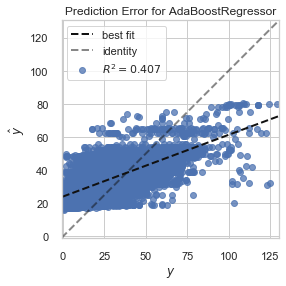

In [321]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from yellowbrick.regressor import PredictionError


model = AdaBoostRegressor()
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

## Gradient Booster

In [322]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', GradientBoostingRegressor())])

In [323]:
N_FEATURES_OPTIONS = [9]
MAX_DEPTH_OPTIONS = [8]

param_grid = [
     {
        'reduce_dim': [TruncatedSVD(algorithm='randomized'), TruncatedSVD(algorithm='arpack')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
    },
    {
        'reduce_dim': [FactorAnalysis(svd_method='randomized'), FactorAnalysis(svd_method='lapack')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
    },
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }

   
]
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
GB_best_params = search.best_params_
GB_best_model = search.best_estimator_

C:\Users\0110900s\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best CV score = 0.649:
Best parameters:  {'reduce_dim': PCA(copy=True, iterated_power=7, n_components=9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), 'reduce_dim__n_components': 9, 'regresson__max_depth': 8}


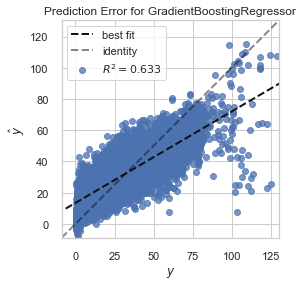

In [324]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from yellowbrick.regressor import PredictionError


model = GradientBoostingRegressor()
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

## SVR

In [325]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', SVR ())])

In [326]:
KERNEL = ['linear']
C = [300]
GAMMA = ['auto']
N_FEATURES_OPTIONS = [5]


param_grid = [
     {
        'reduce_dim': [TruncatedSVD(algorithm='randomized'), TruncatedSVD(algorithm='arpack')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
    },
    {
        'reduce_dim': [FactorAnalysis(svd_method='randomized'), FactorAnalysis(svd_method='lapack')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
    }
]
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVR_best_params = search.best_params_
SVR_best_model = search.best_estimator_


C:\Users\0110900s\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best CV score = 0.511:
Best parameters:  {'reduce_dim': FactorAnalysis(copy=True, iterated_power=3, max_iter=1000, n_components=5,
               noise_variance_init=None, random_state=0,
               svd_method='randomized', tol=0.01), 'reduce_dim__n_components': 5}


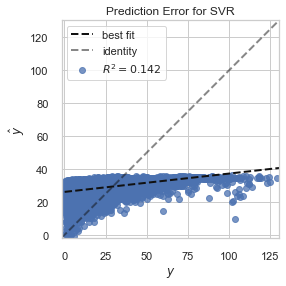

In [327]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from yellowbrick.regressor import PredictionError


model = SVR()
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

## Neural network

In [328]:
from sklearn.neural_network import MLPRegressor

In [329]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', MLPRegressor ())])

In [330]:
ALPHA = [0.001, 0.01, 0.1, 1, 10, 100], 
HIDDEN_LAYER_SIZES = [(6),(11,11),(7,7,7)] 
SOLVER = ['adam'] 
ACTIVATION = ['relu','tanh','identity','logistic'] 
LEARNING_RATE = ['constant','invscaling','adaptive']
N_FEATURES_OPTIONS = [10]
MAX_ITER = [500]

param_grid = [
     {
        'reduce_dim': [TruncatedSVD(algorithm='randomized'), TruncatedSVD(algorithm='arpack')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
    },
    {
        'reduce_dim': [FactorAnalysis(svd_method='randomized'), FactorAnalysis(svd_method='lapack')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
    },

]
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
MLP_best_params = search.best_params_
MLP_best_model = search.best_estimator_

C:\Users\0110900s\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best CV score = 0.629:
Best parameters:  {'reduce_dim': TruncatedSVD(algorithm='arpack', n_components=10, n_iter=5, random_state=None,
             tol=0.0), 'reduce_dim__n_components': 10}


C:\Users\0110900s\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


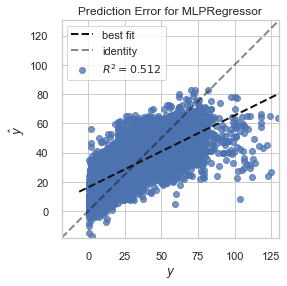

In [331]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from yellowbrick.regressor import PredictionError


model = MLPRegressor()
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

## Plotting data

In [332]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

In [333]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
    _meae = median_absolute_error(y_test, _predicted_values)
          
    return _mse, _mae, _r2, _meae

In [334]:
RF_mse, RF_mae, RF_r2, RF_meae = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2, LR_meae = evaluate_model(X_test, y_test, LR_best_model)
AB_mse, AB_mae, AB_r2, AB_meae = evaluate_model(X_test, y_test, AB_best_model)
GB_mse, GB_mae, GB_r2, GB_meae = evaluate_model(X_test, y_test, GB_best_model)
SVR_mse, SVR_mae, SVR_r2, SVR_meae = evaluate_model(X_test, y_test, SVR_best_model)
MLP_mse, MLP_mae, MLP_r2, MLP_meae = evaluate_model(X_test, y_test, MLP_best_model)

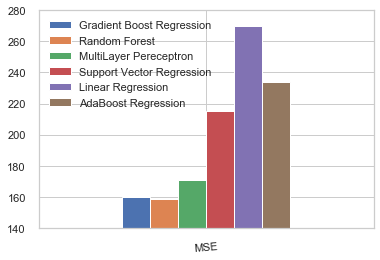

In [335]:
AB_metrics = np.array([AB_mse])
RF_metrics = np.array([RF_mse])
LR_metrics = np.array([LR_mse])
GB_metrics = np.array([GB_mse])
SVR_metrics = np.array([SVR_mse])
MLP_metrics = np.array([MLP_mse])
index = ['MSE']
df_metrics = pd.DataFrame({'Gradient Boost Regression': GB_metrics,'Random Forest': RF_metrics, 'MultiLayer Pereceptron':MLP_metrics,'Support Vector Regression':SVR_metrics,'Linear Regression': LR_metrics, 'AdaBoost Regression': AB_metrics,  }, index=index)
df_metrics.plot.bar(rot=5);plt.ylim((140,280))
plt.legend(loc="upper left")
plt.show()

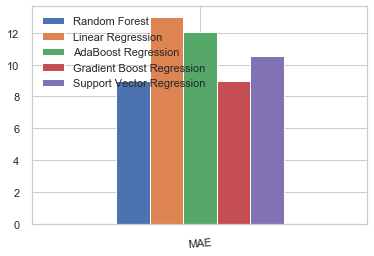

In [336]:
AB_metrics = np.array([AB_mae])
RF_metrics = np.array([RF_mae])
LR_metrics = np.array([LR_mae])
GB_metrics = np.array([GB_mae])
SVR_metrics = np.array([SVR_mae])
MLP_metrics = np.array([MLP_mae])
index = ['MAE']
df_metrics = pd.DataFrame({'Random Forest': RF_metrics, 'Linear Regression': LR_metrics, 'AdaBoost Regression': AB_metrics,'Gradient Boost Regression': GB_metrics,'Support Vector Regression':SVR_metrics, }, index=index)
df_metrics.plot.bar(rot=5)
plt.legend(loc="upper left")
plt.show()

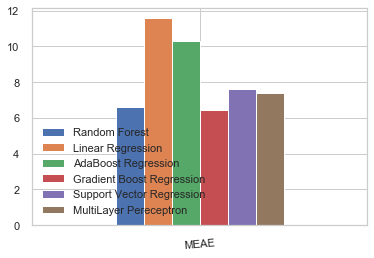

In [337]:
AB_metrics = np.array([AB_meae])
RF_metrics = np.array([RF_meae])
LR_metrics = np.array([LR_meae])
GB_metrics = np.array([GB_meae])
SVR_metrics = np.array([SVR_meae])
MLP_metrics = np.array([MLP_meae])
index = ['MEAE']
df_metrics = pd.DataFrame({'Random Forest': RF_metrics, 'Linear Regression': LR_metrics, 'AdaBoost Regression': AB_metrics,'Gradient Boost Regression': GB_metrics,'Support Vector Regression':SVR_metrics, 'MultiLayer Pereceptron':MLP_metrics}, index=index)
df_metrics.plot.bar(rot=5)
plt.legend(loc="lower left")
plt.show()

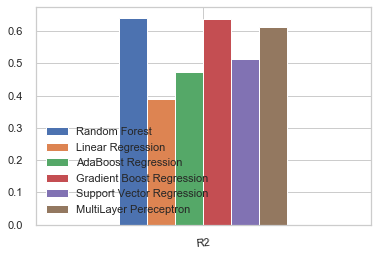

In [339]:
AB_metrics = np.array([AB_r2])
RF_metrics = np.array([RF_r2])
LR_metrics = np.array([LR_r2])
GB_metrics = np.array([GB_r2])
SVR_metrics = np.array([SVR_r2])
MLP_metrics = np.array([MLP_r2])

index = ['R2']
df_metrics = pd.DataFrame({'Random Forest': RF_metrics, 'Linear Regression': LR_metrics, 'AdaBoost Regression': AB_metrics,'Gradient Boost Regression': GB_metrics, 'Support Vector Regression':SVR_metrics, 'MultiLayer Pereceptron':MLP_metrics}, index=index)
df_metrics.plot.bar(rot=5)
plt.legend(loc="lower left")
plt.show()

## Station Name: DUBLIN AIRPORT
### Station Height: 71 M 
### Latitude:53.428  ,Longitude: -6.241


###### date:  -  Date and Time (utc)
###### rain:  -  Precipitation Amount (mm)	  
###### temp:  -  Air Temperature (C)	
###### wetb:  -  Wet Bulb Temperature (C)
###### dewpt: -  Dew Point Temperature (C)             
###### rhum:  -  Relative Humidity (%)
###### vappr: -  Vapour Pressure (hPa)	 
###### msl:   -  Mean Sea Level Pressure (hPa)
###### wdsp:  -  Mean Wind Speed (knot)
###### wddir: -  Predominant Wind Direction (degree)
###### ww:    -  Synop code for Present Weather
###### w:     -  Synop code for Past Weather
###### sun:   -  Sunshine duration (hours)
###### vis:   -  Visibility (m)
###### clht:  -  Cloud height (100's of ft) - 999 if none 
###### clamt: -  Cloud amount
###### ind:   -  Indicator

## Indicators (i)	    Description  - Decode                                                        

irain    Rainfall Indicators:		
                        0. satisfactory. 
	                    1. deposition. 
				        2. trace or sum of precipition. 
				        3. trace or sum of deposition. 
						4. estimate precipitation. 
                        5 estimate deposition. 
						6. estimate trace of precipitation.

itemp		Temperature Indicators: 	
                        0. positive. 
						1. negative. 
						2. positive estimated. 	
						3. negative estimated. 
						4. not available. 

iwb  		Wet Bulb Indicators:    	
                        0:positive. 
						1. negative. 
						2. positive estimated. 
						3. negative estimated. 
				        4. not available. 
						5. frozen negative.

iwdsp		Wind Speed Indicators:		
                        2. Over 60 minutes. 
						4. Over 60 minutes and defective
						6 Over 60 minutes and partially defective. 
						7. n/a

iwddir		Wind Direction Indicators:  	
                        2. Over 60 minutes. 
						4. Over 60 minutes and defective
						6 Over 60 minutes and partially defective. 
						7. n/a

























# GRADIENT BOOSTING

In [156]:

# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     GB_best_params.get('reduce_dim'),
                     GradientBoostingRegressor(n_estimators=10, **transform(GB_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

In [157]:
import sys
filename = 'final_model_GB.sav'
pickle.dump(final_model, open(filename, 'wb'))

In [158]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.604961751467334


# Linear Regression

In [159]:

# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     LR_best_params.get('reduce_dim'),
                     LinearRegression(**transform(LR_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

In [160]:
import sys
filename = 'final_model_LR.sav'
pickle.dump(final_model, open(filename, 'wb'))

In [161]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.45568528967087923


# Random Forest

In [162]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(**transform(RF_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [163]:
import sys
filename = 'final_model_RF.sav'
pickle.dump(final_model, open(filename, 'wb'))

In [164]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8011420215150662


# AdaBoostRegressor

In [165]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     AB_best_params.get('reduce_dim'),
                     AdaBoostRegressor(**transform(AB_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

In [166]:
import sys
filename = 'final_model_AB.sav'
pickle.dump(final_model, open(filename, 'wb'))

In [167]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.40711651473600285


# SVR

In [168]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     SVR_best_params.get('reduce_dim'),
                     SVR(**transform(SVR_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [169]:
import sys
filename = 'final_model_SVR.sav'
pickle.dump(final_model, open(filename, 'wb'))

In [170]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.6293809498176332


# MLP

In [171]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     MLP_best_params.get('reduce_dim'),
                     MLPRegressor(**transform(SVR_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [172]:
import sys
filename = 'final_model_MLP.sav'
pickle.dump(final_model, open(filename, 'wb'))

In [173]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.6628089786712448
